# Multi-Modal Weather Classification CNN

This notebook implements a Convolutional Neural Network (CNN) for weather classification using both image data and weather measurements. The system combines:

1. Image features from sky images
2. Weather measurements (cloud coverage, irradiance, sun obscuration)
3. Time-based features (hour, month)

The model architecture uses two branches:
- CNN branch for processing images
- Dense network branch for weather features
These branches are then combined for final classification.

## 1. Required Imports and Configuration

First, we'll import the required libraries and set up our configuration parameters. For Google Colab, we need to ensure all dependencies are installed.

In [1]:
# Imports
import time
import math
import random
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json as json
import cv2

from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime, timedelta

# Add current directory to path for imports
current_dir = os.path.abspath(os.path.dirname(''))
if current_dir not in sys.path:
    sys.path.append(current_dir)

# Import our custom weather dataset with clustering
from weather_dataset import (
    read_weather_sets_with_clustering,
    get_cluster_characteristics,
    get_weather_classes_from_clusters,
    analyze_weather_distribution
 )

# Configuration and Hyperparameters
# Convolutional Layers
filter_size1 = 3 
num_filters1 = 32
filter_size2 = 3
num_filters2 = 32
filter_size3 = 3
num_filters3 = 64

# Fully-connected layers
fc_size = 128             # Number of neurons in fully-connected layer
weather_fc_size = 64      # Number of neurons for weather features

# Image configuration
num_channels = 3          # RGB images
img_size = 128           # image dimensions (square)
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)

# Weather features configuration
num_weather_features = 7  # cloud_coverage, sun_obscuration_percentage, irradiance, hour_sin, hour_cos, month_sin, month_cos
n_clusters = 5           # Fixed number of weather classes

# Training parameters
batch_size = 32
early_stopping = 10      # Number of epochs to wait for improvement

# Data paths
base_dir = r"D:\Image"  # Your image directory
test_result_dir = os.path.join(base_dir, "test_result")
json_dir = os.path.join(test_result_dir, "json")
checkpoint_dir = os.path.join(test_result_dir, "models")

# Create directories if they don't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Ablation study options: set these before running training
# Remove features by listing their names in ablation_features
# Options: 'cloud_coverage', 'sun_obscuration_percentage', 'irradiance', 'time'
# To remove images, set ablation_no_image = True
ablation_features = []  # e.g., ['cloud_coverage', 'irradiance', 'time']
ablation_no_image = False  # Set True to train without images

## 5. Training and Evaluation

1. Load and preprocess the data
2. Create and train the model
3. Evaluate the results
4. Visualize predictions

In [ ]:
# Load the data
print("[Step 1] Loading weather dataset...")
data = read_weather_sets_with_clustering(
    json_dir=json_dir,
    image_dir=base_dir,
    image_size=img_size,
    use_features=True,
    n_clusters=n_clusters,
    ablation_features=ablation_features,
    ablation_no_image=ablation_no_image
)
print("[Step 1] Done loading weather dataset.")

X_train_images = data.train.images
X_train_features = data.train.features
Y_train = data.train.labels
X_val_images = data.valid.images
X_val_features = data.valid.features
Y_val = data.valid.labels
X_test_images = data.test.images
X_test_features = data.test.features
Y_test = data.test.labels

print(f"Train: {len(X_train_images)} | Validation: {len(X_val_images)} | Test: {len(X_test_images)}")

print("[Step 2] Cluster means for each class:")
for cluster, stats in data.cluster_descriptions.items():
    print(f"Cluster {cluster}: {stats}")

[Step 1] Loading weather dataset...
Reading weather data from JSON files...
Found 80 JSON files
Performing K-means clustering with 5 clusters...
Performing K-means clustering with 5 clusters...


c:\Users\Nitro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering completed. Cluster distribution: [36573  8657 14362  9019 25377]
Loaded 93988 images with clustered weather data
Weather class distribution: [36573  8657 14362  9019 25377]
Loaded 93988 images with clustered weather data
Weather class distribution: [36573  8657 14362  9019 25377]
[Step 1] Done loading weather dataset.
Train: 65791 | Validation: 18798 | Test: 9399
[Step 2] Cluster means for each class:
Cluster 0: {'mean_cloud_coverage': 0.962747275312389, 'mean_irradiance': 4.555368988051295, 'mean_sun_obscuration_percentage': 0.9090603341262681, 'count': 36573}
Cluster 1: {'mean_cloud_coverage': 0.36964737206884596, 'mean_irradiance': 8.766359015825342, 'mean_sun_obscuration_percentage': 0.05455724846944669, 'count': 8657}
Cluster 2: {'mean_cloud_coverage': 0.8888853014900432, 'mean_irradiance': 20.752430023673586, 'mean_sun_obscuration_percentage': 0.02301416237292856, 'count': 14362}
Cluster 3: {'mean_cloud_coverage': 0.4787387515245593, 'mean_irradiance': 19.2956757955427

In [3]:
# TensorFlow 2.x and Keras Training (no tf.Session)
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Prepare data for Keras (reshape images, features, labels)
X_train_images = X_train_images.reshape((-1, img_size, img_size, num_channels))
X_val_images = X_val_images.reshape((-1, img_size, img_size, num_channels))
X_test_images = X_test_images.reshape((-1, img_size, img_size, num_channels))

# Image branch
image_input = layers.Input(shape=(img_size, img_size, num_channels))
x = layers.Conv2D(num_filters1, filter_size1, activation='relu', padding='same')(image_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(num_filters2, filter_size2, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(num_filters3, filter_size3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(fc_size, activation='relu')(x)

# Weather branch
weather_input = layers.Input(shape=(num_weather_features,))
w = layers.Dense(weather_fc_size, activation='relu')(weather_input)

# Combine branches
combined = layers.Concatenate()([x, w])
output = layers.Dense(n_clusters, activation='softmax')(combined)

# Build and compile model
model = models.Model(inputs=[image_input, weather_input], outputs=output)
model.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
 ]

# Train the model
print("[Step 7] Training the model with Keras...")
history = model.fit([X_train_images, X_train_features], Y_train,
                    validation_data=([X_val_images, X_val_features], Y_val),
                    batch_size=batch_size, epochs=30, callbacks=callbacks)
with open('training_history3.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved to training_history3.json")
print("[Step 7] Model training complete.")

[Step 7] Training the model with Keras...
Epoch 1/30
Epoch 1/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 289s 139ms/step - accuracy: 0.8535 - loss: 0.3632 - val_accuracy: 0.9240 - val_loss: 0.2003
Epoch 2/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 289s 139ms/step - accuracy: 0.8535 - loss: 0.3632 - val_accuracy: 0.9240 - val_loss: 0.2003
Epoch 2/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 255s 124ms/step - accuracy: 0.9389 - loss: 0.1621 - val_accuracy: 0.9443 - val_loss: 0.1429
Epoch 3/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 255s 124ms/step - accuracy: 0.9389 - loss: 0.1621 - val_accuracy: 0.9443 - val_loss: 0.1429
Epoch 3/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 250s 122ms/step - accuracy: 0.9571 - loss: 0.1138 - val_accuracy: 0.9519 - val_loss: 0.1154
Epoch 4/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 250s 122ms/step - accuracy: 0.9571 - loss: 0.1138 - val_accuracy: 0.9519 - val_loss: 0.1154
Epoch 4/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 250s 122ms/step - accuracy: 0.9640 - loss: 0.0942 - val_accuracy: 0.9681 - val_loss: 0.0864
Epoch 5/3

588/588 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9838 - loss: 0.0413
588/588 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9838 - loss: 0.0413


Validation Accuracy: 98.38%
Model saved to D:\Image\test_result\models\weather_cnn_model3.h5
Model saved to D:\Image\test_result\models\weather_cnn_model3.h5
294/294 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9830 - loss: 0.0430
294/294 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9830 - loss: 0.0430
Test Accuracy: 98.30%
Test Loss: 0.0430
Test Accuracy: 98.30%
Test Loss: 0.0430
294/294 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Accuracy: 98.30%
Precision: 98.30%
Recall: 98.30%
F1-score: 98.30%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3657
           1       0.98      0.97      0.97       866
           2       0.97      0.97      0.97      1436
           3       0.97      0.97      0.97       902
           4       0.98      0.98      0.98      2538

    accuracy                           0.98      9399
   macro avg       0.98      0.98      0.98      9399
weighted avg       0.98  

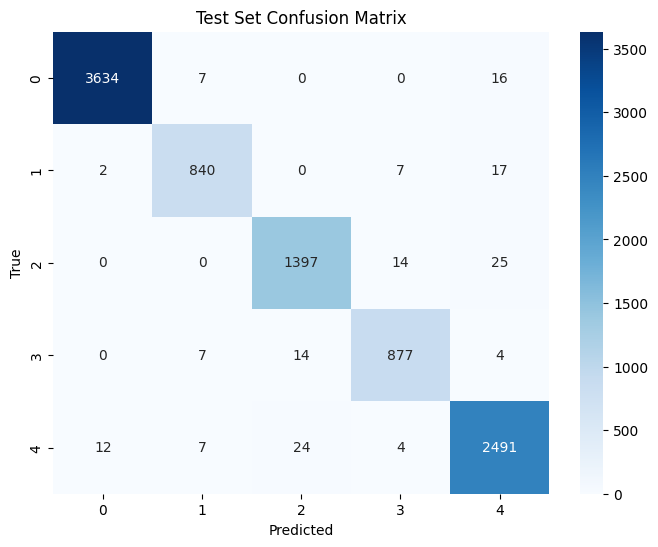


Example errors from test set:


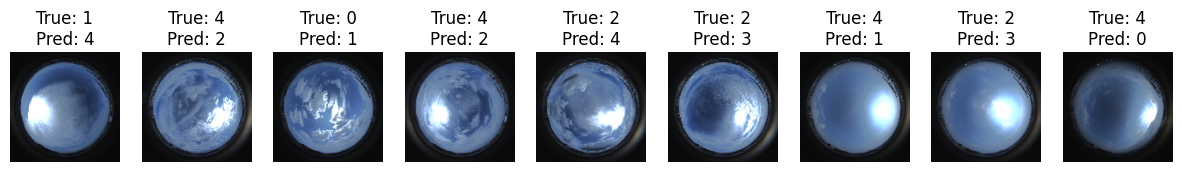

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate and save
val_loss, val_acc = model.evaluate([X_val_images, X_val_features], Y_val)
print(f"Validation Accuracy: {val_acc*100:.4f}%")
model.save(os.path.join(checkpoint_dir, "weather_cnn_model3.h5"))
model.save(os.path.join(checkpoint_dir, "weather_cnn_model3.keras"))
print(f"Model saved to {os.path.join(checkpoint_dir, 'weather_cnn_model3.h5')}")

# Final test evaluation
test_loss, test_acc = model.evaluate([X_test_images, X_test_features], Y_test)
print(f"Test Accuracy: {test_acc*100:.4f}%")
print(f"Test Loss: {test_loss:.4f}")

# Test set classification report
y_test_pred = model.predict([X_test_images, X_test_features])
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(Y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy*100:.4f}%")
print(f"Precision: {precision*100:.4f}%")
print(f"Recall: {recall*100:.4f}%")
print(f"F1-score: {f1*100:.4f}%")

print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=[str(c) for c in range(n_clusters)], zero_division=0))

# Plot confusion matrix for test set
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_clusters), yticklabels=range(n_clusters))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Set Confusion Matrix")
plt.show()

# Plot collision heatmap (misclassification matrix)
collision_matrix = np.zeros_like(cm)
for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:
            collision_matrix[i, j] = cm[i, j]
plt.figure(figsize=(8,6))
sns.heatmap(collision_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=range(n_clusters), yticklabels=range(n_clusters))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Collision Heatmap (Misclassifications)")
plt.show()

# Show example errors (misclassified images) from test set
num_examples = 9
incorrect_mask = y_test_pred_classes != y_test_true_classes
incorrect_images = X_test_images[incorrect_mask]
incorrect_true = y_test_true_classes[incorrect_mask]
incorrect_pred = y_test_pred_classes[incorrect_mask]

if len(incorrect_images) > 0:
    print("\nExample errors from test set:")
    idxs = np.random.choice(len(incorrect_images), min(num_examples, len(incorrect_images)), replace=False)
    fig, axes = plt.subplots(1, len(idxs), figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(incorrect_images[idxs[i]].reshape(img_size, img_size, num_channels))
        ax.set_title(f"True: {incorrect_true[idxs[i]]}\nPred: {incorrect_pred[idxs[i]]}")
        ax.axis('off')
    plt.show()
else:
    print("No errors found in test set!")

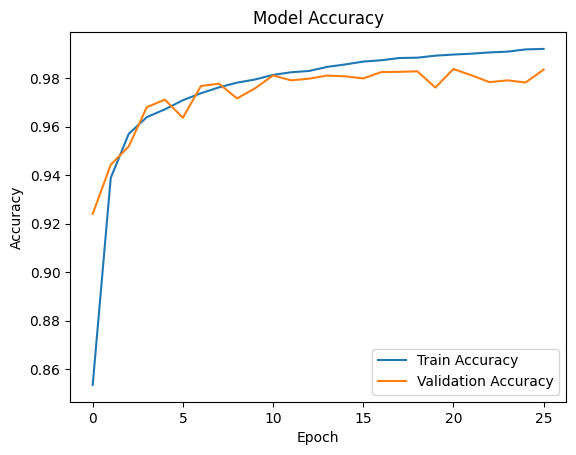

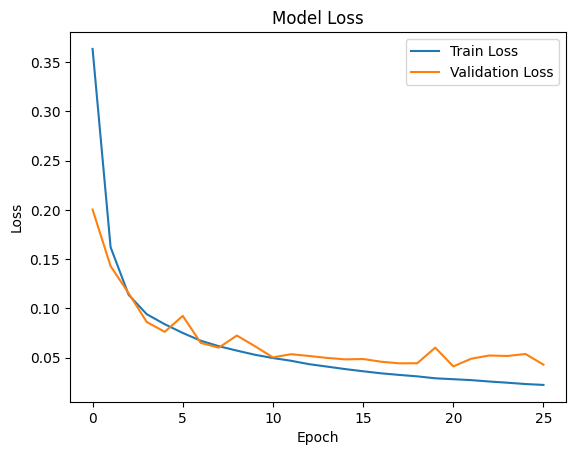

In [5]:
# Load training history from JSON file
with open('training_history3.json', 'r') as f:
    history = json.load(f)

# Plot accuracy
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()